In [1]:
%matplotlib inline
import cvxpy as cvx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
sketches = ["moment", "tdigest", "yahoo", "sampling", "spark_gk", "histogram"]
# sketches = ["moment", "histogram"]

In [3]:
def get_error(sorted_data, x, p, is_int=False):
    if is_int:
        x = round(x)
    n = len(sorted_data)
    li = np.searchsorted(sorted_data, x, side="left")
    ri = np.searchsorted(sorted_data, x, side="right")
    qi = int(p * n)
    if ri < qi:
        return (qi-ri)*1.0/n
    elif li > qi:
        return (li-qi)*1.0/n
    else:
        return 0.0

In [4]:
def gen_plots(df, sorted_data, name):
    dft = df[df["trial"] > 0].groupby(
        ["sketch", "size_param", "q"]
    )[
        "quantile_estimate", "train_time", 
        "query_time", "space", "merge_time",
        "bound_size"
    ].mean()
    dft = dft.reset_index()
    dft["error"] = dft.apply(
        lambda r: get_error(
            sorted_data, r["quantile_estimate"], r["q"],
            is_int=False
        ),
        axis=1
    )
    dft["rerror"] = dft["error"] / np.minimum(dft["q"],(1-dft["q"]))
    dfg = dft.groupby([
        "sketch", "size_param"
    ])[
        "train_time","merge_time", "query_time", 
        "space", "error", "rerror", "bound_size"
      ].mean()
    dfs = dfg.reset_index().sort_values(["size_param"])
    
    plt.figure()
    for alg in sketches:
        c_df = dfs[dfs["sketch"] == alg]
        plt.loglog(
            c_df["space"], 
            (c_df["query_time"])*1e-9,
            label=alg,
            marker="."
        )
    plt.xlabel("Size (bytes)")
    plt.ylabel("Query Time (s)")
    plt.legend(loc=4)
    plt.title(name)
    plt.savefig("{}_query_time.pdf".format(name))
    
    n = len(orig_data)
    plt.figure()
    for alg in sketches:
        c_df = dfs[dfs["sketch"] == alg]
        plt.loglog(
            c_df["space"], 
            (c_df["merge_time"])/n,
            label=alg,
    #         lw=0,
            marker="."
        )
    plt.xlabel("Size (bytes)")
    plt.ylabel("Merge Time (ns)")
    plt.legend(loc=4)
    plt.title(name)
    plt.savefig("{}_merge_time.pdf".format(name))
    
    plt.figure()
    for alg in sketches:
        c_df = dfs[dfs["sketch"] == alg]
        plt.loglog(
            c_df["space"],
            c_df["error"], 
            label=alg,
            marker="."
        )
    plt.xlabel("Size (Bytes)")
    plt.ylabel("Avg Error")
    plt.legend()
    plt.title(name)
    plt.savefig("{}_error.pdf".format(name))
    
    plt.figure()
    for alg in sketches:
        c_df = dfs[dfs["sketch"] == alg]
        plt.loglog(
            c_df["space"],
            c_df["bound_size"], 
            label=alg,
            marker="."
        )
    plt.xlabel("Size (Bytes)")
    plt.ylabel("Avg Bound Size")
    plt.legend()
    plt.title(name)
    plt.savefig("{}_bound.pdf".format(name))
    
    return dft

In [5]:
orig_df = pd.read_csv("../../datasets/l_internet-mi-2013-11-01_09.csv")
orig_data = orig_df["l_internet"]
sorted_data = np.sort(orig_data)

/usr/local/lib/python3.6/site-packages/matplotlib/ticker.py:2210: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


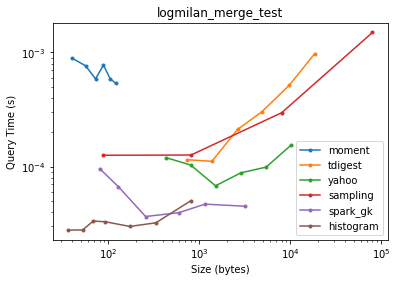

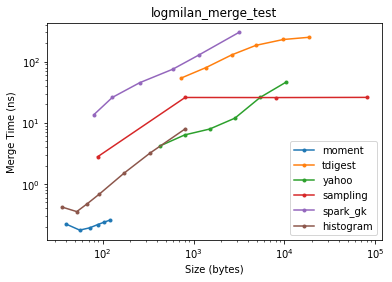

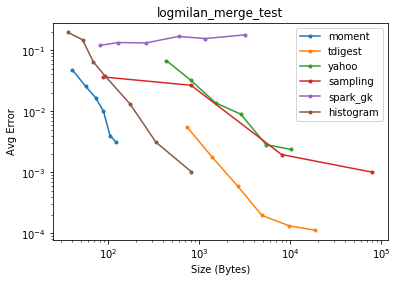

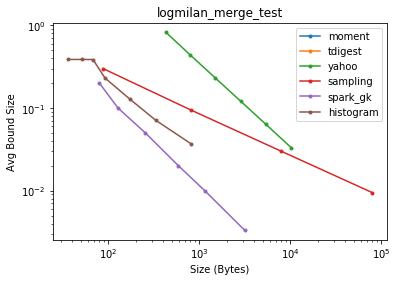

In [6]:
df = pd.read_csv("../javamsketch/results/logmilan_merge_1514658496.csv")
dft = gen_plots(df, sorted_data, "logmilan_merge_test")